In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

combined_returns_df = pd.read_csv('COMBINED_RETURNS.csv')

# Convert DataFrame to numpy array
combined_returns = combined_returns_df.values

# Calculate the mean returns and the covariance matrix for optimization
mean_returns = np.mean(combined_returns, axis=0)
cov_matrix = np.cov(combined_returns, rowvar=False)

print(mean_returns)

print("Covariance Matrix:")
print(pd.DataFrame(cov_matrix, columns=combined_returns_df.columns, index=combined_returns_df.columns))






[0.00378477 0.00488902 0.00709633 0.00842891]
Covariance Matrix:
              ASX   Zone_1A    Zone_6    Zone_7
ASX      0.001585 -0.000139 -0.000081 -0.000161
Zone_1A -0.000139  0.001817  0.000356  0.000574
Zone_6  -0.000081  0.000356  0.004357  0.000457
Zone_7  -0.000161  0.000574  0.000457  0.001749


In [57]:
import numpy as np

def sharpe_ratio(weights, returns, risk_free_rate, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return (portfolio_return - risk_free_rate) / portfolio_volatility

def sharpe_ratio_gradient(weights, returns, risk_free_rate, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sr = (portfolio_return - risk_free_rate) / portfolio_volatility

    gradient = (returns - risk_free_rate - sr * np.dot(cov_matrix, weights) / portfolio_volatility) / portfolio_volatility
    return -gradient

def sharpe_ratio_hessian(weights, cov_matrix):
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    first_term = cov_matrix / volatility
    second_term = np.dot(np.dot(cov_matrix, weights), np.dot(weights.T, cov_matrix)) / (volatility**3)
    return (first_term - second_term)

def newton_optimization(returns, cov_matrix, risk_free_rate, num_iterations, initial_weights):
    weights = initial_weights
    sharpe_values = []
    weights_history = []

    for i in range(num_iterations):
        gradient = sharpe_ratio_gradient(weights, returns, risk_free_rate, cov_matrix)
        hessian = sharpe_ratio_hessian(weights, cov_matrix)
        hessian_inv = np.linalg.inv(hessian)
        
        # Update weights using Newton's method
        weights -= np.dot(hessian_inv, gradient)
        
        # Project weights onto the feasible set (sum to 1 and non-negative)
        weights = np.maximum(weights, 0)
        weights /= np.sum(weights)
        
        # Store Sharpe ratio and weights history
        current_sharpe = sharpe_ratio(weights, returns, risk_free_rate, cov_matrix)
        sharpe_values.append(current_sharpe)
        weights_history.append(weights.copy())
        
    return weights, sharpe_values, weights_history

# Example usage
num_assets = 4
num_iterations = 20
initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
risk_free_rate = 0.0204
returns = mean_returns  

optimal_weights, sharpe_values, weights_history = newton_optimization(returns, cov_matrix, risk_free_rate, num_iterations, initial_weights)
print("Optimal portfolio weights:", optimal_weights)

# Create a DataFrame to display the optimal weights in a table
assets = ['ASX', 'Trading Zone 1A', 'Trading Zone 6', 'Trading Zone 7']
optimal_weights_df = pd.DataFrame(np.round(optimal_weights, 4), index=assets, columns=['Optimal Allocation'])
optimal_weights_df.replace(0, '0', inplace=True)  # Simplify 0 to '0'

# Display the table
print("Optimal Portfolio Weights Table:")
print(optimal_weights_df)


Optimal portfolio weights: [0.         0.         0.07522439 0.92477561]
Optimal Portfolio Weights Table:
                Optimal Allocation
ASX                              0
Trading Zone 1A                  0
Trading Zone 6              0.0752
Trading Zone 7              0.9248


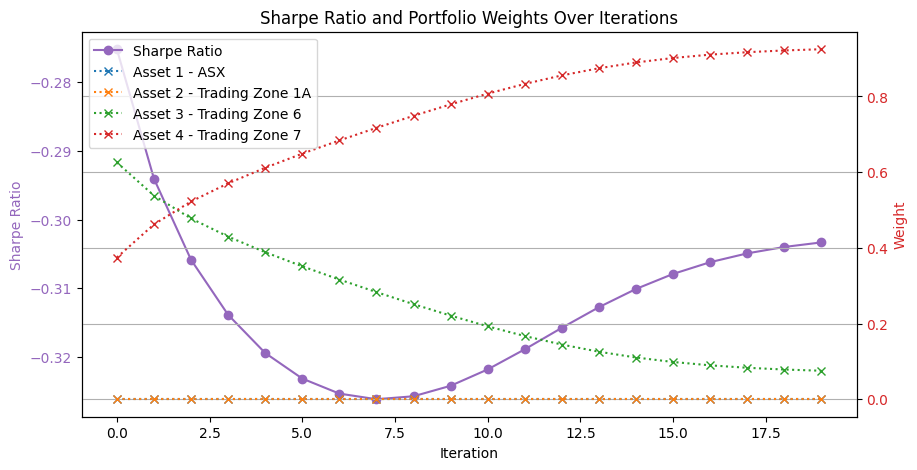

In [58]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Sharpe Ratio on the primary y-axis
color = 'tab:purple'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sharpe Ratio', color=color)
ax1.plot(sharpe_values, color=color, marker='o', label='Sharpe Ratio')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the weights
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Weight', color=color)
weights_history = np.array(weights_history)
for i in range(num_assets):
    ax2.plot(weights_history[:, i], label=f'Asset {i+1} - {assets[i]}', marker='x', linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show the plot
plt.title('Sharpe Ratio and Portfolio Weights Over Iterations')
plt.grid(True)
plt.show()